### Importing required packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Utility function to plot and find moving average

In [9]:
def moving_average(data, window_size):
    # Convert data to a pandas series
    series = pd.Series(data)
    
    # Calculate the moving average
    moving_avg = series.rolling(window=window_size).mean().tolist()
    
    return moving_avg

def plot_list(list_values):
    n = len(list_values)
    x_values = range(n)
    plt.plot(x_values, list_values)
    plt.xlabel('Episode')
    plt.ylabel('Rewards\Episode')
    plt.title('List Plot')
    plt.show()


#### Hyperparameter combination with alpha = 0.5, gamma = 0.9, epsilon = 0.10

----------------------------------
| -0.434 | 0.629  | 1.81   | 3.122  | 4.58   | 
----------------------------------
| 0.0    | 1.81   | 3.122  | 0.0    | 6.2    | 
----------------------------------
| 1.81   | 3.122  | 4.58   | 6.2    | 8.0    | 
----------------------------------
| -0.673 | 0.0    | 6.2    | 8.0    | 10.0   | 
----------------------------------
| -2.262 | -2.262 | 0.0    | 9.99   | 0.0    | 
----------------------------------


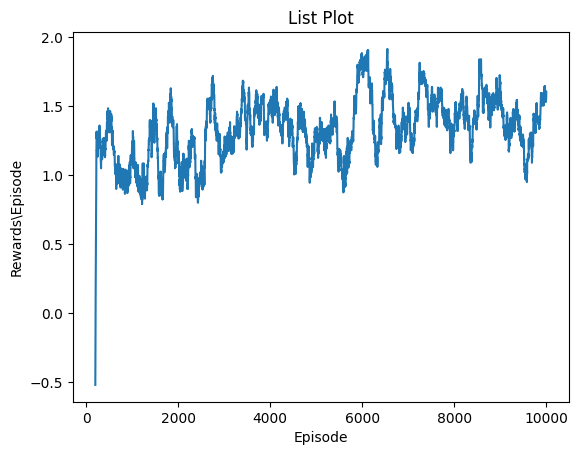

In [13]:
# global variables
BOARD_ROWS = 5
BOARD_COLS = 5
WIN_STATE = (4, 4)
LOSE_STATE = [(1, 0), (1, 3), (3, 1), (4, 2)]
START = (0, 0)
DEBUG = False  # set to true to enable verbose output


class State:
    def __init__(self, state=START):        
        self.state = state
        self.isEnd = False        

    def get_reward(self):
        if self.state == WIN_STATE:
            return 10        
        elif self.state in LOSE_STATE:
            return -5
        else:
            return -1

    def is_end_func(self):
        if (self.state == WIN_STATE) or (self.state in LOSE_STATE):
            self.isEnd = True

    def nxt_position(self, action):
        if action == 0:                
            nxt_state = (self.state[0] - 1, self.state[1])
        elif action == 1:
            nxt_state = (self.state[0] + 1, self.state[1])
        elif action == 2:
            nxt_state = (self.state[0], self.state[1] - 1)
        else:
            nxt_state = (self.state[0], self.state[1] + 1)
            
        if (nxt_state[0] >= 0) and (nxt_state[0] <BOARD_ROWS):
            if (nxt_state[1] >= 0) and (nxt_state[1] <BOARD_COLS):
                return nxt_state  # if next state legal
        return self.state  # Any move off the grid leaves state unchanged


class Agent:

    def __init__(self, alpha = 0.5, gamma = 0.9, epsilon = 0.10):
        self.states = []
        self.actions = [0, 1, 2, 3]  # up, down, left, right
        self.State = State()
        self.discount = gamma
        self.lr = alpha
        self.eps = epsilon
        self.rewards = list()
        
        # initialise state values
        self.action_values = {}        
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                for k in range(len(self.actions)):
                    self.action_values[(i, j, k)] = 0.0  # set initial value to 0, for Q(s,a)
        
        self.new_action_values = []

    def choose_action(self, current_state):
        # choose action according to policy eps-greedy
        if np.random.uniform(0, 1) <= self.eps:
            action = np.random.choice(self.actions)
            if DEBUG:
                print("selecting random action")
        else:
            action = self.best_action(current_state)
        return action
    
    def decay_epsilon(self, decay_rate):
        return self.eps * decay_rate

    def take_action(self, action):
        position = self.State.nxt_position(action)
        self.State.state = position

    def best_action(self, state):
        best = -1
        max_val = -100000000
        for a in self.actions:
            q_val = self.action_values[state[0], state[1], a]
            if q_val >= max_val:
                max_val = q_val
                best = a
        return best

    def q_max(self, state):
        best = self.best_action(state)
        return self.action_values[state[0], state[1], best]

    def q_learning(self, episodes, epsilon = False, decay_rate = 0.8):

        # Q-learning implementation
        x = 0  # episode counter
        while x < episodes:
            reward_sum = 0
            # Init S
            self.State.isEnd = False
            self.State.state = START  # Re init S Start state
            step = 0

            if DEBUG:
                print("**** Beginning episode", x, "****")
                self.show_values()

            while True:  # repeat for each step of the episode (until S is terminal)

                # Store current state for Q update
                current_state = (self.State.state[0], self.State.state[1])

                # Choose action A from S using policy derived from Q (e-greedy)
                action = self.choose_action(current_state)

                # Take action A observe R and next State S'
                self.take_action(action)
                reward = self.State.get_reward()
                reward_sum += reward
                self.State.is_end_func()
                next_state = self.State.state[0], self.State.state[1]

                # Update state action values
                old_q = self.action_values[current_state[0], current_state[1], action]
                max_q = self.q_max(next_state)
                new_q = old_q + self.lr * (reward + self.discount * max_q - old_q)
                self.action_values[current_state[0], current_state[1], action] = new_q

                step += 1
                if DEBUG:
                    print("step", step, "state", current_state, "action", action, "reward", reward,
                          "next_state", next_state, "old_q", old_q, "max_q", max_q, "new_q", new_q)

                # Check if s is terminal
                if self.State.isEnd:
                    self.rewards.append(reward_sum)
                    break

                # S <- S' automatically when I took the action                    

            x += 1           
            if epsilon == True:
                self.eps = self.decay_epsilon(decay_rate)
        return self.rewards
    def show_values(self):
        for i in range(0, BOARD_ROWS):
            print('----------------------------------')
            out = '| '
            for j in range(0, BOARD_COLS):
                mx_nxt_value = -1000
                for a in self.actions:
                    nxt_value = self.action_values[(i, j, a)]
                    if nxt_value >= mx_nxt_value:
                        mx_nxt_value = nxt_value                
                out += str(round(mx_nxt_value, 3)).ljust(6) + ' | '
            print(out)
        print('----------------------------------')


if __name__ == "__main__":
    # ----------------------------------------Hyper parameter 1-------------------------------------------------------------
    ag = Agent()
    rewards = ag.q_learning(10000)
    ag.show_values()
    plot_list(moving_average(rewards, 200))


#### Hyperparameter 2 combination with alpha = 0.5, gamma = 0.9, epsilon = 0.10 and Epsilon decay

----------------------------------
| -0.434 | 0.629  | 1.81   | -2.262 | -0.83  | 
----------------------------------
| 0.0    | -2.196 | 3.122  | 0.0    | 3.016  | 
----------------------------------
| -1.855 | 0.337  | 4.58   | 1.565  | 7.378  | 
----------------------------------
| -2.138 | 0.0    | 6.2    | 8.0    | 10.0   | 
----------------------------------
| -2.262 | -2.262 | 0.0    | 5.0    | 0.0    | 
----------------------------------


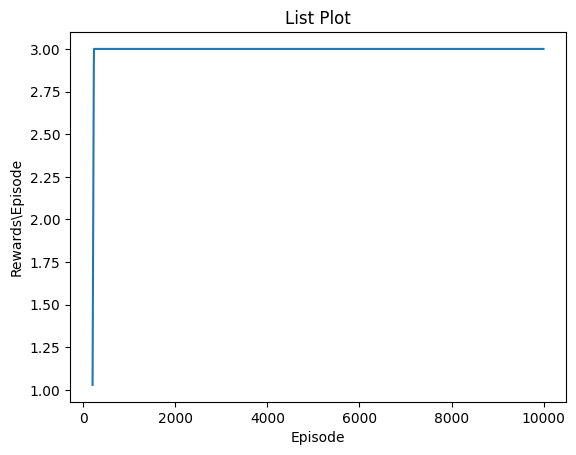

In [14]:
ag1 = Agent()
rewards = ag1.q_learning(10000, True, 0.9)
ag1.show_values()
plot_list(moving_average(rewards, 200))

#### Hyperparameter combination with alpha = 0.1, gamma = 0.1, epsilon = 0.05 and Epsilon decay

----------------------------------
| -1.111 | -1.111 | -1.111 | -1.11  | -1.1   | 
----------------------------------
| 0.0    | -1.111 | -1.11  | 0.0    | -1.0   | 
----------------------------------
| -1.11  | -1.11  | -1.1   | -1.0   | -0.0   | 
----------------------------------
| -1.109 | 0.0    | -1.0   | -0.0   | 10.0   | 
----------------------------------
| -1.109 | -1.108 | 0.0    | 3.439  | 0.0    | 
----------------------------------


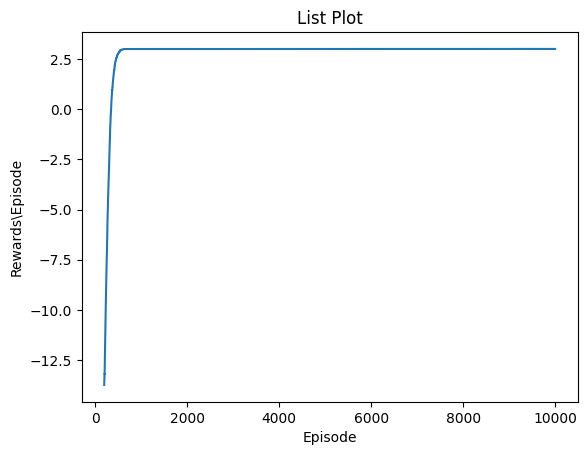

In [18]:
ag2 = Agent(0.1, 0.1, 0.05)
rewards = ag2.q_learning(10000, True, 0.9)
ag2.show_values()
plot_list(moving_average(rewards, 200))